# Embeddings Part 3
# Going Through the Use Cases
Here we show some representative use cases. We will use the Amazon fine-food reviews dataset for the following examples.


In [ ]:
# Install libraries that aren't in the Python standard library

# Numpy is used for numerical operations, essential for handling arrays which are
# often used in data manipulations for AI and embeddings.
%pip install numpy

# Pandas is utilized for data manipulation and analysis; it provides data structures
# and operations for manipulating numerical tables and time series, which is helpful
# in preprocessing data for AI models.
%pip install pandas

# Scipy is a library used for scientific computing which includes modules for
# optimization, linear algebra, integration, and statistics. It's often used in AI
# for calculating distances and other operations that support embeddings.
%pip install scipy

# OpenAI's library is needed to interact with OpenAI's API, useful for accessing
# various AI models and tools, potentially including those related to embeddings.
%pip install openai

# Tiktoken (assuming the library's name and availability are correct) might be a
# specialized library for tokenization or similar tasks in NLP, which could be
# relevant to preparing data for embedding-based AI models.
%pip install tiktoken


In [185]:
# Standard library imports
import os
import pickle
import re
from ast import literal_eval

# Related third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.manifold import TSNE

# Local application/library specific imports
from openai import OpenAI
import tiktoken


In [186]:
# Create an instance of the OpenAI client
# This assumes you have set an environment variable called OPENAI_API_KEY
client = OpenAI()

First, let's see what trying to answer without using RAG looks like

In [187]:
from openai import OpenAI

# an example question about the Amazon reviews
query = "What people hated their food?"

response = client.chat.completions.create(
    messages=[
        {'role': 'system', 'content': 'You answer questions about Amazon fine food reviews.'},
        {'role': 'user', 'content': query},
    ],
    model='gpt-4-turbo',
    temperature=0,
)

print(response.choices[0].message.content)

I don't have access to specific user data or individual reviews from Amazon. However, in general, negative reviews on Amazon's fine food products can stem from various reasons such as poor taste, issues with packaging, perceived lack of value for money, product freshness, or discrepancies between the product description and the actual item received. If you're interested in specific reviews or trends in customer satisfaction, you can check the product review section on Amazon's website for detailed feedback from customers.


## Obtaining the Embeddings
The dataset contains a total of 568,454 food reviews Amazon users left up to October 2012. We will use a subset of 1,000 most recent reviews for illustration purposes. The reviews are in English and tend to be positive or negative. Each review has a ProductId, UserId, Score, review title (Summary) and review body (Text). For example:

| PRODUCT ID  | USER ID        | SCORE | SUMMARY             | TEXT                                           |
|-------------|----------------|-------|---------------------|------------------------------------------------|
| B001E4KFG0  | A3SGXH7AUHU8GW | 5     | Good Quality Dog Food | I have bought several of the Vitality canned... |
| B00813GRG4  | A1D87F6ZCVE5NK | 1     | Not as Advertised   | Product arrived labeled as Jumbo Salted Peanut... |



We will combine the review summary and review text into a single combined text. The model will encode this combined text and output a single vector embedding.

In [188]:
# utility function to get the file size
def get_file_size(file_path):
    """ Returns the size of the file in megabytes. """
    size_bytes = os.path.getsize(file_path)
    size_mb = size_bytes / (1024 * 1024)  # Convert from bytes to megabytes
    return size_mb


In [189]:

# Define the path to the input data file
input_data_path = "./EmbeddingsDemoAssets/fine_food_reviews_1k.csv"

# Read the CSV file using pandas and set the first column as the index
df = pd.read_csv(input_data_path, index_col=0)

# Select only the relevant columns from the dataframe
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]

# Drop rows with any missing values
df = df.dropna()

# Drop rows with any missing values
df = df.drop_duplicates()

# Combine the 'Summary' and 'Text' columns into a new column with a formatted string
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)

# Display the first 5 rows of the modified dataframe
df.head(5)


,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ...."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...


### Small Model Embedding
Now let's embed using the small model first

In [190]:
# NOTE: This can take a couple of minutes to run 

# main utility function to get the embeddings
def get_embedding(text, model="text-embedding-3-small"):
    # Replace newlines in the text with spaces for consistent formatting
    text = text.replace("\n", " ")
    # Request the embedding for the cleaned text and return the embedding
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Apply the `get_embedding` function to each entry in the 'combined' column and store the results
df['embedding'] = df['combined'].apply(lambda x: get_embedding(x))

# Save the dataframe with embeddings to a CSV file, omitting the index
df.to_csv('./EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_1k.csv', index=False)

# Display the first 5 rows of the modified dataframe
df.head(5)


,Time,ProductId,UserId,Score,Summary,Text,combined,embedding
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[0.0359942801296711, -0.02117965929210186, -0...."
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[0.01144526805728674, 0.0342588946223259, -0.0..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....","[0.003300713375210762, 0.012644506990909576, -..."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,"[-0.002887785667553544, 0.014631008729338646, ..."
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,"[0.012054475955665112, -0.05606513097882271, 0..."


In [191]:
# Get the size of the data file
file_path = './EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_1k.csv'
size_mb = get_file_size(file_path)
print(f"The size of the file is {size_mb:.2f} MB.")

The size of the file is 33.43 MB.


### Large Model Embedding
Let's embed using the large model next.

In [192]:
# NOTE: This can take several minutes to run

# utility function to get the embeddings with reduced dimensions
def get_embedding_large(text, model="text-embedding-3-large"):
    # Replace newlines in the text with spaces for consistent formatting
    text = text.replace("\n", " ")
    # Request the embedding for the cleaned text and return the embedding
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Apply the `get_embedding_large` function to each entry in the 'combined' column and store the results
df['embedding'] = df['combined'].apply(lambda x: get_embedding_large(x))

# Save the dataframe with embeddings to a CSV file, omitting the index
df.to_csv('./EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_large_1k.csv', index=False)

# Display the first 5 rows of the modified dataframe
df.head(5)

,Time,ProductId,UserId,Score,Summary,Text,combined,embedding
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[-0.01042067352682352, 0.006103187799453735, -..."
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[0.007291625719517469, -0.026603516191244125, ..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....","[-0.0028845469933003187, 0.0052615199238061905..."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,"[0.011740384623408318, -0.012508317828178406, ..."
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,"[-0.011891649104654789, 0.011205235496163368, ..."


In [193]:
# Get the size of the data file
file_path = './EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_large_1k.csv'
size_mb = get_file_size(file_path)
print(f"The size of the file is {size_mb:.2f} MB.")

The size of the file is 66.51 MB.


### Loading the Data
Here we show how to load the data into a dataframe from a CSV file to make it ready to be used again when needed. 

In [194]:

# Load the CSV file into a pandas DataFrame
df_load = pd.read_csv('./EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_large_1k.csv')

# Convert the string representation of embeddings in the 'embedding' column to numpy arrays
# By converting the embeddings from string format to numpy arrays immediately after loading, 
# we ensure that the data is in a ready-to-use state for any subsequent analysis or processing steps.
df_load['embedding'] = df_load['embedding'].apply(eval).apply(np.array)

# Display the first 5 rows of the loaded dataframe
df_load.head(5)

,Time,ProductId,UserId,Score,Summary,Text,combined,embedding
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[-0.01042067352682352, 0.006103187799453735, -..."
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[0.007291625719517469, -0.026603516191244125, ..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....","[-0.0028845469933003187, 0.0052615199238061905..."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,"[0.011740384623408318, -0.012508317828178406, ..."
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,"[-0.011891649104654789, 0.011205235496163368, ..."


### Reducing the Dimensions
Using larger embeddings, for example storing them in a vector store for retrieval, generally costs more and consumes more compute, memory and storage than using smaller embeddings.

Both of the new embedding models were trained with a technique that allows developers to trade-off performance and cost of using embeddings. Specifically, developers can shorten embeddings (i.e. remove some numbers from the end of the sequence) without the embedding losing its concept-representing properties.

In [195]:

# Define the path to the input data file
input_data_path = "./EmbeddingsDemoAssets/fine_food_reviews_1k.csv"

# Read the CSV file using pandas and set the first column as the index
df_reduced_dims = pd.read_csv(input_data_path, index_col=0)

# Select only the relevant columns from the dataframe
df_reduced_dims = df_reduced_dims[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]

# Drop rows with any missing values
df_reduced_dims = df_reduced_dims.dropna()

# Drop rows with any missing values
df_reduced_dims = df_reduced_dims.drop_duplicates()

# Combine the 'Summary' and 'Text' columns into a new column with a formatted string
df_reduced_dims["combined"] = (
    "Title: " + df_reduced_dims.Summary.str.strip() + "; Content: " + df_reduced_dims.Text.str.strip()
)

# Display the first 5 rows of the modified dataframe
df_reduced_dims.head(5)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ...."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...


In [196]:
# NOTE: This can take a couple of minutes to run

# utility function to get the embeddings with reduced dimensions
def get_embedding_reduced_dims(text, model="text-embedding-3-large"):
    # Replace newlines in the text with spaces for consistent formatting
    text = text.replace("\n", " ")
    # Request the embedding for the cleaned text and return the embedding
    return client.embeddings.create(input=[text], model=model,dimensions=1024).data[0].embedding

# Apply the `get_embedding_reduced_dims` function to each entry in the 'combined' column and store the results
df_reduced_dims['embedding'] = df_reduced_dims['combined'].apply(lambda x: get_embedding_reduced_dims(x))

# Save the dataframe with embeddings to a CSV file, omitting the index
df_reduced_dims.to_csv('./EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_reduced_dims_1k.csv', index=False)

# Display the first 5 rows of the modified dataframe
df.head(5)


,Time,ProductId,UserId,Score,Summary,Text,combined,embedding
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[-0.01042067352682352, 0.006103187799453735, -..."
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[0.007291625719517469, -0.026603516191244125, ..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....","[-0.0028845469933003187, 0.0052615199238061905..."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,"[0.011740384623408318, -0.012508317828178406, ..."
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,"[-0.011891649104654789, 0.011205235496163368, ..."


In [197]:

# Get the size of the data file
file_path = './EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_reduced_dims_1k.csv'
size_mb = get_file_size(file_path)
print(f"The size of the file is {size_mb:.2f} MB.")

The size of the file is 22.46 MB.


## Question Answering Using Embeddings-Based Search
There are many common cases where the model is not trained on data which contains key facts and information you want to make accessible when generating responses to a user query. One way of solving this is to put additional information into the context window of the model. This is effective in many use cases but leads to higher token costs. The other way is to use RAG to obtain the information.

First, let's load up the file with the (large) embeddings in them.

In [198]:

# Load the CSV file into a pandas DataFrame
df_search = pd.read_csv('./EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_large_1k.csv')

# Convert the string representation of embeddings in the 'embedding' column to numpy arrays
# By converting the embeddings from string format to numpy arrays immediately after loading, 
# we ensure that the data is in a ready-to-use state for any subsequent analysis or processing steps.
df_search['embedding'] = df_search['embedding'].apply(eval).apply(np.array)

# Display the first 5 rows of the loaded dataframe
df_search.head(5)

,Time,ProductId,UserId,Score,Summary,Text,combined,embedding
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[-0.01042067352682352, 0.006103187799453735, -..."
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[0.007291625719517469, -0.026603516191244125, ..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....","[-0.0028845469933003187, 0.0052615199238061905..."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,"[0.011740384623408318, -0.012508317828178406, ..."
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,"[-0.011891649104654789, 0.011205235496163368, ..."


### Relatedness
Now let's write some code to show the related reviews based on a ranking score. In this case, we will set up a function to take in our query string and compute the relateness scores for reviews. Then it will show us the top 5 revies in terms of relatedness score. 

In [199]:

# Define a function that ranks strings from a pandas DataFrame based on their relatedness to a given query string.
def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - distance.cosine(x, y), # use cosine similarity as the relatedness function
    top_n: int = 100,
    threshold: float = 0.001  # Minimum score difference to consider for ranking
) -> tuple[list[str], list[float]]:
    """
    Retrieve the top 'n' strings related to a query string from a DataFrame, based on a custom relatedness function.

    Parameters:
    query (str): The string to compare other strings against.
    df (pd.DataFrame): DataFrame containing the strings and their embeddings.
    relatedness_fn (callable): A function that computes the relatedness score between two embeddings. By default, 
                               it uses the cosine similarity between embeddings.
    top_n (int): The number of top related strings to return.
    threshold (float): The minimum difference between scores needed to consider one string more related than another.

    Returns:
    tuple[list[str], list[float]]: A tuple containing two lists:
                                   1. The top 'n' strings most related to the query.
                                   2. Their corresponding relatedness scores.
    """
    
    # Retrieve the embedding for the query string using the large model.
    query_embedding_response = client.embeddings.create(
        model="text-embedding-3-large",
        input=query,
    )
    # Extract the embedding data from the response.
    query_embedding = query_embedding_response.data[0].embedding

    # Compute the relatedness of each string in the DataFrame to the query string.
    strings_and_relatednesses = [
        (row["combined"], relatedness_fn(query_embedding, row["embedding"]))
        for i, row in df.iterrows()
    ]

    # Sort the list of tuples by the relatedness score in descending order (most related first).
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)

    # Initialize a list to store the filtered results and a variable to track the last accepted score.
    filtered = []
    last_score = -1

    # Filter strings to meet the threshold criteria and limit the number of results to 'top_n'.
    for item in strings_and_relatednesses:
        if abs(item[1] - last_score) > threshold:
            filtered.append(item)
            last_score = item[1]
        if len(filtered) >= top_n:
            break

    # Unzip the tuples to separate strings and their relatedness scores.
    strings, relatednesses = zip(*filtered)

    # Return only the top 'n' results as specified by the function arguments.
    return strings[:top_n], relatednesses[:top_n]



In [200]:
# This code performs a search to find the top 5 items related to the phrase "don't like the taste" 
# from a DataFrame 'df_search' using the previously defined 'strings_ranked_by_relatedness' function.

# Call the function 'strings_ranked_by_relatedness' with the query string, DataFrame, and specify the number 
# of top related items to return (top_n=5).
strings, relatednesses = strings_ranked_by_relatedness("don't like the taste", df_search, top_n=5)

# Loop over each string and its corresponding relatedness score.
# The 'zip' function combines the two lists 'strings' and 'relatednesses' so that items from both lists 
# can be accessed in a single loop iteration.
for string, relatedness in zip(strings, relatednesses):
    # Print a formatted string that includes a visual separator and the relatedness score formatted to three decimal places.
    print(f"\n========================\n{relatedness=:.3f}")
    
    # The 'display' function is typically used in Jupyter Notebooks or similar environments to render objects in a more
    # visually appealing manner than the basic print function. Here, it is used to display the string from the DataFrame.
    display(string)



relatedness=0.658


"Title: Don't like the taste; Content: I do not like sour taste and this has a sour kind of taste which i don't like. The smell isn't that great either"


relatedness=0.493


"Title: Doesn't taste good...; Content: I didn't like the flavor of this root beer snow cone syrup, it has a bitter flavor.<br /><br />It is a great deal tho so it's too bad it doesn't taste good. :("


relatedness=0.472


"Title: No Thanks!; Content: I LOVE the Blue Sky Wild Raspberry but I cannot stand the Black Cherry.  It doesn't have much flavor and it has an awful aftertaste.  UGH!"


relatedness=0.451


"Title: Didn't like it; Content: Quite personally, I didn't like it.  For me, it had no flavour at all.  It only tasted better when I added some nutmeg (ran out of cinnamon) and milk.  On the brightside, it did help me get rid of my cold :')"


relatedness=0.444


'Title: I did not like it.; Content: I did not like the taste of this Illy cappuccino drink.  I like coffee and coffee drinks in general, and I was looking forward to trying something new, but this product had a slight metallic/chemical aftertaste that, while not strong, was present in sufficient strength to make it less than pleasing to me.  I much prefer the Starbucks Mocha Cappuccino drink that tastes only of coffee, milk, sugar and chocolate.  I do not know if it is the metal container that imparts the aftertaste to the Illy product.  The similar Starbucks drink comes in a glass container that I suppose could have something to do with its fresher taste.  Also, since my opinion is certainly subjective, others may like the Illy drink and be just as justified in their opinion.'

## Asking Questions
Now that we have the ability to find reviews that are relevant we can ask questions based on the reviews retrieved and put into the context window. We will need a number of items to make sure we are getting good data and that we don't go over our token limit of 128k.

Let's start with a function to get a token count for any string passed into it.

In [201]:

def num_tokens(text: str, model: str = 'gpt-4-turbo') -> int:
    """
    Return the number of tokens in a string using a specified model's tokenizer.

    Parameters:
        text (str): The input text to tokenize.
        model (str): The model whose tokenizer is used, defaulting to 'gpt-4-turbo'.

    Returns:
        int: The number of tokens that the text is divided into by the tokenizer.
    """

    # Get the tokenizer configuration specific to the model
    encoding = tiktoken.encoding_for_model(model)

    # Encode the text using the tokenizer and count the number of tokens
    return len(encoding.encode(text))


Next, let's create a function to pull reviews from our dataframe that can be put into the GPT context window

In [202]:
def query_message(query: str, df: pd.DataFrame, model: str, token_budget: int) -> str:
    """
    Construct a message for GPT using related texts from a DataFrame, staying within a token limit.

    Parameters:
        query (str): The user's query to find related text.
        df (pd.DataFrame): DataFrame containing potential related texts.
        model (str): Model identifier for tokenization.
        token_budget (int): Maximum number of tokens allowed in the final message.

    Returns:
        str: A message constructed with introductory text, relevant reviews, and the query.
    """

    # Retrieve ranked strings and their relatedness from the dataframe
    strings, relatednesses = strings_ranked_by_relatedness(query, df)

    # Introduction to include in the message
    introduction = 'Use the below Amazon food reviews to answer the subsequent question. If the answer cannot be found in the reviews, write "I could not find an answer."'

    # Formatting the query into a question format
    question = f"\n\nQuestion: {query}"

    # Initialize the message with the introduction text
    message = introduction

    # Iterate over each related string to build the message
    for string in strings:
        # Format the string as an Amazon Food Review
        next_article = f'\n\nAmazon Food Review:\n"""\n{string}\n"""'

        # Check if adding the next article exceeds the token budget
        if num_tokens(message + next_article + question, model=model) > token_budget:
            break  # Stop adding articles if token budget is exceeded
        else:
            message += next_article  # Append the article if within budget

    # Return the final message with the question appended
    return message + question


Next, we create a function to actually allow us to ask questions from the GPT model

In [203]:
def ask(
    query: str,
    df: pd.DataFrame,
    model: str = 'gpt-4-turbo',
    token_budget: int = 4096 - 500,
    print_message: bool = False
) -> str:
    """
    Generate an answer to a query using GPT, based on a DataFrame of related texts.

    Parameters:
        query (str): The query to be answered.
        df (pd.DataFrame): DataFrame containing texts and embeddings.
        model (str): Model identifier for tokenization, default is 'gpt-4-turbo'.
        token_budget (int): Maximum number of tokens for the generated message, default is 3596.
        print_message (bool): Whether to print the constructed message, default is False.

    Returns:
        str: The generated response from GPT based on the query and provided texts.
    """

    # Generate a message using related texts from the DataFrame
    message = query_message(query, df, model=model, token_budget=token_budget)

    # Optionally print the constructed message
    if print_message:
        print(message)

    # Set up the conversation format for the GPT model
    messages = [
        {"role": "system", "content": "You answer questions about Amazon Food Reviews."},
        {"role": "user", "content": message}
    ]

    # Request a completion from the GPT model
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0  # Use deterministic mode for reproducibility
    )

    # Extract the response message from the completion
    response_message = response.choices[0].message.content

    return response_message


Finally, let's ask our question

In [204]:
# Submit our question to the model
ask("What are the top 3 reviews that indicate people don't like the food? Give me the title and text of the reviews in this format: Title: <title>; Content: <content>",df_search)


"Title: Inedible; Content: I am one of the least picky eaters that I know, but I had to throw my bowl out after a few spoons of this. It was disgusting and inedible. I wonder if anyone at these big companies try their products before marketing them. The flavor was heavily artificial with strong off-notes of bitterness and tree bark. Dont believe me? Go ahead and try it.\n\nTitle: God Awful; Content: As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once. Both as a food aficionado and a lover of bacon, I just had to pick this up. One taste caused me to throw out my sandwich, and subsequently throw out the entire jar of unused mayonnaise. I would give this less than 1 star, if I could. Steer clear from this unless you're a major tool who has no sensibility past buying bacon-everything.\n\nTitle: Yuk! And who goes to Amazon to buy cereal?????; Content: This stuff tasted like (insert favorite negative adjective that Amazon won't print). I

The output looks funky so let's pretty it up a bit. We can always try a variety of techniques, like outputting JSON, but, for now, we will just use regular expressions to deal with the output.

In [205]:

def format_response(response: str) -> str:
    """
    Format a string containing multiple entries with titles and contents into a readable format.

    Parameters:
        response (str): The string response containing multiple formatted entries.

    Returns:
        str: A formatted string where each entry is separated and clearly labeled.
    """
    
    # Compile a pattern to match entries formatted as "Title: <title>; Content: <content>"
    pattern = re.compile(r"Title: (.*?); Content: (.*?)(?=\nTitle: |$)", re.S)
    
    # Extract all matches using the pattern
    matches = pattern.findall(response)
    
    # List to store formatted entries
    formatted_lines = []
    
    # Format each match with proper numbering and formatting
    for index, (title, content) in enumerate(matches, start=1):
        # Strip and replace newline characters in content
        content = content.strip().replace('\n', ' ')
        # Append formatted title and content to the list
        formatted_lines.append(f"{index}. Title: **{title.strip()}**")
        formatted_lines.append(f"   Content: {content}")
        formatted_lines.append('')  # Blank line for separation

    # Join all formatted lines into a single string
    return '\n'.join(formatted_lines)

# Example usage with a provided function response
response = ask("What are the top 3 reviews that indicate people don't like the food? Give me the title and text of the reviews in this format: Title: <title>; Content: <content>",df_search)
formatted_output = format_response(response)
print(formatted_output)




1. Title: **Inedible**
   Content: I am one of the least picky eaters that I know, but I had to throw my bowl out after a few spoons of this. It was disgusting and inedible. I wonder if anyone at these big companies try their products before marketing them. The flavor was heavily artificial with strong off-notes of bitterness and tree bark. Dont believe me? Go ahead and try it.

2. Title: **God Awful**
   Content: As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once. Both as a food aficionado and a lover of bacon, I just had to pick this up. One taste caused me to throw out my sandwich, and subsequently throw out the entire jar of unused mayonnaise. I would give this less than 1 star, if I could. Steer clear from this unless you're a major tool who has no sensibility past buying bacon-everything.

3. Title: **New Recipe is Awful**
   Content: These used to be my favorite animal crackers but Austin has recently changed their recipe t

## Semantic Search
Now we will do straight searching for similarities using an algorithm called "cosine similarity" to determine how similar the words we are looking for are to words in the reviews.

First let's load data into our dataframe.

In [206]:
# load data into our dataframe and turn the embeddings into numpy arrays
df_semantic_search = pd.read_csv('./EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_large_1k.csv')

df_semantic_search["embedding"] = df_semantic_search.embedding.apply(literal_eval).apply(np.array)

### Cosine Similarity
Now let's use cosine similarity, like we did before, to get relatedness scores for reviews

In [207]:
# This code performs a search to find the top 5 items related to the phrase "don't like the taste" 
# from a DataFrame 'df_search' using the previously defined 'strings_ranked_by_relatedness' function.

# Call the function 'strings_ranked_by_relatedness' with the query string, DataFrame, and specify the number 
# of top related items to return (top_n=5).
strings, relatednesses = strings_ranked_by_relatedness("don't like the taste", df_semantic_search, top_n=5)

# Loop over each string and its corresponding relatedness score.
# The 'zip' function combines the two lists 'strings' and 'relatednesses' so that items from both lists 
# can be accessed in a single loop iteration.
for string, relatedness in zip(strings, relatednesses):
    # Print a formatted string that includes a visual separator and the relatedness score formatted to three decimal places.
    print(f"\n========================\n{relatedness=:.3f}")
    
    # The 'display' function is typically used in Jupyter Notebooks or similar environments to render objects in a more
    # visually appealing manner than the basic print function. Here, it is used to display the string from the DataFrame.
    display(string)


relatedness=0.658


"Title: Don't like the taste; Content: I do not like sour taste and this has a sour kind of taste which i don't like. The smell isn't that great either"


relatedness=0.493


"Title: Doesn't taste good...; Content: I didn't like the flavor of this root beer snow cone syrup, it has a bitter flavor.<br /><br />It is a great deal tho so it's too bad it doesn't taste good. :("


relatedness=0.472


"Title: No Thanks!; Content: I LOVE the Blue Sky Wild Raspberry but I cannot stand the Black Cherry.  It doesn't have much flavor and it has an awful aftertaste.  UGH!"


relatedness=0.451


"Title: Didn't like it; Content: Quite personally, I didn't like it.  For me, it had no flavour at all.  It only tasted better when I added some nutmeg (ran out of cinnamon) and milk.  On the brightside, it did help me get rid of my cold :')"


relatedness=0.444


'Title: I did not like it.; Content: I did not like the taste of this Illy cappuccino drink.  I like coffee and coffee drinks in general, and I was looking forward to trying something new, but this product had a slight metallic/chemical aftertaste that, while not strong, was present in sufficient strength to make it less than pleasing to me.  I much prefer the Starbucks Mocha Cappuccino drink that tastes only of coffee, milk, sugar and chocolate.  I do not know if it is the metal container that imparts the aftertaste to the Illy product.  The similar Starbucks drink comes in a glass container that I suppose could have something to do with its fresher taste.  Also, since my opinion is certainly subjective, others may like the Illy drink and be just as justified in their opinion.'

### Eucleidean Distance
Now let's try Eucleidian Distance to see the difference

In [208]:

def rank_strings_by_euclidean(query: str, df: pd.DataFrame, top_n: int = 100) -> tuple[list[str], list[float]]:
    """
    Returns a list of strings and their relatedness scores sorted from most related to least.
    The relatedness is determined using the Euclidean distance.
    
    Parameters:
        query (str): The query string to compare against dataframe strings.
        df (pd.DataFrame): DataFrame containing strings and their embeddings.
        top_n (int): The number of top related strings to return.

    Returns:
        tuple: A tuple containing two lists; one for strings and one for their corresponding relatedness scores.
    """

    # Retrieve the embedding for the query string from a model
    query_embedding_response = client.embeddings.create(
        model='text-embedding-3-large',
        input=query,
    )
    # Extract the embedding from the response
    query_embedding = query_embedding_response.data[0].embedding

    # Function to calculate negative Euclidean distance between two embeddings
    def calculate_relatedness(x, y):
        return -distance.euclidean(x, y)

    # Create a list of tuples containing strings from the DataFrame and their relatedness to the query
    strings_and_relatednesses = [
        (row["combined"], calculate_relatedness(query_embedding, row["embedding"]))
        for i, row in df.iterrows()  # Iterate over DataFrame rows
    ]

    # Sort the list of tuples by relatedness, descending
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)

    # Unzip the sorted list into two lists: one for strings and another for relatedness scores
    strings, relatednesses = zip(*strings_and_relatednesses)

    # Return the top N related strings and their scores
    return strings[:top_n], relatednesses[:top_n]


In [220]:
# This code performs a search to find the top 5 items related to the phrase "don't like the taste" 
# from a DataFrame 'df_search' using the previously defined 'strings_ranked_by_relatedness' function.

# Call the function 'strings_ranked_by_relatedness_ed' with the query string, DataFrame, and specify the number 
# of top related items to return (top_n=5).
strings, relatednesses = rank_strings_by_euclidean("don't like the taste", df_semantic_search, top_n=5)

# Loop over each string and its corresponding relatedness score.
# The 'zip' function combines the two lists 'strings' and 'relatednesses' so that items from both lists 
# can be accessed in a single loop iteration.
for string, relatedness in zip(strings, relatednesses):
    # Print a formatted string that includes a visual separator and the relatedness score formatted to three decimal places.
    print(f"\n========================\n{relatedness=:.3f}")
    
    # The 'display' function is typically used in Jupyter Notebooks or similar environments to render objects in a more
    # visually appealing manner than the basic print function. Here, it is used to display the string from the DataFrame.
    display(string)


relatedness=-0.826


"Title: Don't like the taste; Content: I do not like sour taste and this has a sour kind of taste which i don't like. The smell isn't that great either"


relatedness=-1.007


"Title: Doesn't taste good...; Content: I didn't like the flavor of this root beer snow cone syrup, it has a bitter flavor.<br /><br />It is a great deal tho so it's too bad it doesn't taste good. :("


relatedness=-1.027


"Title: No Thanks!; Content: I LOVE the Blue Sky Wild Raspberry but I cannot stand the Black Cherry.  It doesn't have much flavor and it has an awful aftertaste.  UGH!"


relatedness=-1.047


"Title: Didn't like it; Content: Quite personally, I didn't like it.  For me, it had no flavour at all.  It only tasted better when I added some nutmeg (ran out of cinnamon) and milk.  On the brightside, it did help me get rid of my cold :')"


relatedness=-1.054


'Title: I did not like it.; Content: I did not like the taste of this Illy cappuccino drink.  I like coffee and coffee drinks in general, and I was looking forward to trying something new, but this product had a slight metallic/chemical aftertaste that, while not strong, was present in sufficient strength to make it less than pleasing to me.  I much prefer the Starbucks Mocha Cappuccino drink that tastes only of coffee, milk, sugar and chocolate.  I do not know if it is the metal container that imparts the aftertaste to the Illy product.  The similar Starbucks drink comes in a glass container that I suppose could have something to do with its fresher taste.  Also, since my opinion is certainly subjective, others may like the Illy drink and be just as justified in their opinion.'

## Recommendation Example
Because shorter distances between embedding vectors represent greater similarity, embeddings can be useful for recommendation.

Below, we illustrate a basic recommender. It takes in a list of strings and one 'source' string, computes their embeddings, and then returns a ranking of the strings, ranked from most similar to least similar. As a concrete example, we apply a version of this function to the AG news dataset (sampled down to 2,000 news article descriptions) to return the top 5 most similar articles to any given source article.

### Load the Data
First, let's load our data into a dataframe

In [210]:
# load data from dataset
# full dataset available at http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html
dataset_path = "./EmbeddingsDemoAssets/AG_news_samples.csv"
df = pd.read_csv(dataset_path)

# Number of examples to display
n_examples = 5

# Print the title, description, and label of the top n examples
for idx, row in df.head(n_examples).iterrows():
    print("\nTitle:", row['title'])
    print("Description:", row['description'])
    print("Label:", row['label'])



Title: World Briefings
Description: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.
Label: World

Title: Nvidia Puts a Firewall on a Motherboard (PC World)
Description: PC World - Upcoming chip set will include built-in security features for your PC.
Label: Sci/Tech

Title: Olympic joy in Greek, Chinese press
Description: Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.
Label: Sports

Title: U2 Can iPod with Pictures
Description: SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.
Label: Sci/Tech

Title: The Dream Factory
Description: Any product, any shape, any size -- manufactured o

### Build a Cache to Save Embeddings
Before getting embeddings for these articles, let's set up a cache to save the embeddings we generate. In general, it's a good idea to save your embeddings so you can re-use them later. If you don't save them, you'll pay again each time you compute them again.

The cache is a dictionary that maps tuples of (text, model) to an embedding, which is a list of floats. The cache is saved as a Python pickle file.

In [211]:

# Path to the embedding cache file
embedding_cache_path = "./EmbeddingsDemoAssets/recommendations_embeddings_cache.pkl"

# Try to load the embedding cache if it exists, otherwise initialize an empty dictionary
try:
    with open(embedding_cache_path, "rb") as embedding_cache_file:
        embedding_cache = pickle.load(embedding_cache_file)
except FileNotFoundError:
    embedding_cache = {}

# Define a function to retrieve embeddings from the cache or request via the API if not found
def embedding_from_string(string: str, model: str = "text-embedding-3-large", cache=embedding_cache) -> list:
    """
    Retrieve the embedding of a given string using a specified model.
    Utilizes a cache to avoid redundant API calls.

    Parameters:
        string (str): The string to embed.
        model (str): The model to use for embedding.
        cache (dict): The cache to store and retrieve embeddings.

    Returns:
        list: The embedding vector of the string.
    """
    # Check if the embedding is already in the cache
    if (string, model) not in cache:
        # Assume get_embedding_large is a function that requests the embedding from an API
        cache[(string, model)] = get_embedding_large(string, model)
        # Save the updated cache to disk
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(cache, embedding_cache_file)
    return cache[(string, model)]


Let's make sure everything is working by getting an embeddding

In [212]:
# Example usage: Retrieving and displaying embeddings for descriptions from the dataset

# Fetch the first description from the dataset and print it
example_string = df["description"].iloc[0]  # Use iloc for safer access by index
print(f"\nExample string: {example_string}")

# Retrieve the embedding for the first description and print the first 10 dimensions
example_embedding = embedding_from_string(example_string)
print(f"\nExample embedding: {example_embedding[:10]}...")

# Fetch the tenth description from the dataset and print it
example_string_10 = df["description"].iloc[9]  # Use iloc for safer access by index
print(f"\nExample string: {example_string_10}")

# Retrieve the embedding for the tenth description and print the first 10 dimensions
example_embedding_10 = embedding_from_string(example_string_10)
print(f"\nExample embedding: {example_embedding_10[:10]}...")



Example string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

Example embedding: [0.00740843964740634, -0.014154672622680664, -0.0029247470665723085, -0.0001465822570025921, -0.009395060129463673, -0.011871438473463058, 0.011623110622167587, 0.012857850641012192, -0.023936020210385323, 0.0016158538637682796]...

Example string: The Microsoft CEO says one way to stem growing piracy of Windows and Office in emerging markets is to offer low-cost computers.

Example embedding: [-0.018890535458922386, -0.012971138581633568, -0.021860403940081596, -0.01110649574548006, -0.056468188762664795, 0.0030105519108474255, -0.0035597742535173893, 0.029291855171322823, 0.02150781638920307, 0.02474890649318695]...


### Recommend Similar Articles Based on Embeddings
To find similar articles, let's follow a three-step plan:

1. Get the similarity embeddings of all the article descriptions
2. Calculate the distance between a source title and all other articles
3. Print out the other articles closest to the source title

In [213]:

def distances_from_embeddings(query_embedding, embeddings, distance_metric="cosine"):
    """
    Calculate distances from the query embedding to each embedding in the list.

    Parameters:
        query_embedding (array): The embedding of the query string.
        embeddings (list of arrays): A list of embeddings to compare against.
        distance_metric (str): The metric used to calculate distance, default is "cosine".

    Returns:
        list: Distances from the query embedding to each embedding in the list.
    """
    distances = []
    for emb in embeddings:
        dist = distance.cosine(query_embedding, emb) if emb is not None else np.inf
        distances.append(dist)
    return distances

def indices_of_nearest_neighbors_from_distances(distances, k=1):
    """
    Return indices of the k nearest neighbors based on the given distances.

    Parameters:
        distances (list): List of distances from the query.
        k (int): Number of nearest neighbors to return.

    Returns:
        array: Indices of the k nearest neighbors.
    """
    sorted_indices = np.argsort(distances)
    return sorted_indices[1:k+1]  # Skip the first index assuming it's the query itself

def print_recommendations_from_strings(strings, index_of_source_string, model='text-embedding-3-large', k_nearest_neighbors=1):
    """
    Print out the k nearest neighbors of a given string based on embeddings.

    Parameters:
        strings (list): List of strings to consider for neighbors.
        index_of_source_string (int): Index of the string to find neighbors for.
        model (str): Model used for generating embeddings.
        k_nearest_neighbors (int): Number of nearest neighbors to print.

    Returns:
        list: Indices of the nearest neighbors.
    """
    embeddings = [embedding_from_string(string, model=model) for string in strings]
    query_embedding = embeddings[index_of_source_string]
    distances = distances_from_embeddings(query_embedding, embeddings)
    indices_of_nearest_neighbors = indices_of_nearest_neighbors_from_distances(distances, k_nearest_neighbors + 1)

    query_string = strings[index_of_source_string]
    print(f"Source string: {query_string}")
    
    # Filter out the source string index and print recommendations
    recommendations = [i for i in indices_of_nearest_neighbors if i != index_of_source_string]
    for idx, rec_idx in enumerate(recommendations[:k_nearest_neighbors], 1):
        print(f"""
        --- Recommendation #{idx} (Nearest Neighbor #{idx} of {k_nearest_neighbors}) ---
        String: {strings[rec_idx]}
        Distance: {distances[rec_idx]:0.3f}
        """)

    return recommendations


In [214]:
# NOTE: This code block may take a few minutes to run
article_descriptions = df["description"].tolist()

tony_blair_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=0,  # articles similar to the first one about Tony Blair
    k_nearest_neighbors=5,  # 5 most similar articles
)

Source string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

        --- Recommendation #1 (Nearest Neighbor #1 of 5) ---
        String: THE re-election of British Prime Minister Tony Blair would be seen as an endorsement of the military action in Iraq, Prime Minister John Howard said today.
        Distance: 0.520
        

        --- Recommendation #2 (Nearest Neighbor #2 of 5) ---
        String: AP - Police defused a bomb in a town near Prime Minister Silvio Berlusconi's villa on the island of Sardinia on Wednesday shortly after British Prime Minister Tony Blair finished a visit there with the Italian leader.
        Distance: 0.523
        

        --- Recommendation #3 (Nearest Neighbor #3 of 5) ---
        String: Israel is prepared to back a Middle East conference convened by Tony Blair early

In [215]:
# NOTE: This code block may take a few minutes to run
chipset_security_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=1,  # let's look at articles similar to the second one about a more secure chipset
    k_nearest_neighbors=5,  # let's look at the 5 most similar articles
)


Source string: PC World - Upcoming chip set will include built-in security features for your PC.

        --- Recommendation #1 (Nearest Neighbor #1 of 5) ---
        String: PC World - Updated antivirus software for businesses adds intrusion prevention features.
        Distance: 0.476
        

        --- Recommendation #2 (Nearest Neighbor #2 of 5) ---
        String: Chips that help a computer's main microprocessors perform specific types of math problems are becoming a big business once again.\
        Distance: 0.512
        

        --- Recommendation #3 (Nearest Neighbor #3 of 5) ---
        String: originally offered on notebook PCs -- to its Opteron 32- and 64-bit x86 processors for server applications. The technology will help servers to run 
        Distance: 0.526
        

        --- Recommendation #4 (Nearest Neighbor #4 of 5) ---
        String: PC World - Symantec, McAfee hope raising virus-definition fees will move users to\  suites.
        Distance: 0.549
       

### Put The Results into JSON Format
JSON is a popular structured format that is used worldwide for transmitting text information. Let's put our Tony Blair articles in JSON format.

In [216]:

# Create a list of dictionaries for each selected article, including available details
articles_json = [
    {
        'title': df.loc[index, 'title'],
        'description': df.loc[index, 'description']
    } for index in tony_blair_articles
]

# Optionally convert to a JSON string if needed for file storage or transmission
articles_json_string = json.dumps(articles_json, indent=4)

print(articles_json_string)


[
    {
        "title": "Blair win would endorse war: PM",
        "description": "THE re-election of British Prime Minister Tony Blair would be seen as an endorsement of the military action in Iraq, Prime Minister John Howard said today."
    },
    {
        "title": "Bomb Found in Town Near Berlusconi Villa (AP)",
        "description": "AP - Police defused a bomb in a town near Prime Minister Silvio Berlusconi's villa on the island of Sardinia on Wednesday shortly after British Prime Minister Tony Blair finished a visit there with the Italian leader."
    },
    {
        "title": "Sharon gives Blair #39;s Middle East summit an unexpected boost",
        "description": "Israel is prepared to back a Middle East conference convened by Tony Blair early next year despite having expressed fears that the British plans were over-ambitious and designed "
    },
    {
        "title": "Blair faces vote amidst hostage crisis",
        "description": "The anguish of hostage Kenneth Bigley in

## Visualizing the Data in 2D Space
The size of the embeddings varies with the complexity of the underlying model. In order to visualize this high dimensional data we use the t-SNE algorithm to transform the data into two dimensions.

We color the individual reviews based on the star rating which the reviewer has given:

1-star: red

2-star: yellow

3-star: black

4-star: blue

5-star: green

#### About the Plot
The plot you're looking at is a visualization created by using t-SNE to reduce the dimensions of a high-dimensional data set, in this case, embeddings from Amazon food reviews. The axes (both X and Y) in this plot do not have inherent meanings as they would in, say, a standard Cartesian plane where X might represent time and Y might represent speed. Instead, these axes are abstract and are simply two dimensions onto which the high-dimensional data has been projected to facilitate visualization.

In a t-SNE plot, the exact positions of the points are determined by the algorithm's attempt to preserve the local structure of the data, which means points that were close together in the high-dimensional space should appear close together in the t-SNE projection, too. The numeric values of the axes are not directly interpretable; they don't correspond to any specific attribute of the data. What matters here is the relative positioning of the points.

Each point on the plot represents a food review, and the color indicates the rating score associated with each review (1 through 5, corresponding to the colors ["red", "yellow", "black", "blue", "green"]). The points are spread out in a way that reflects the underlying patterns and relationships in the review data, with the hope being that reviews with similar sentiments and content are positioned nearer to each other.

So, when you look at this plot, rather than focusing on the numerical values of the axes, you should focus on the clusters of points, their proximity, and perhaps any discernible patterns of colors, which could indicate groupings or ratings similarities among the reviews.

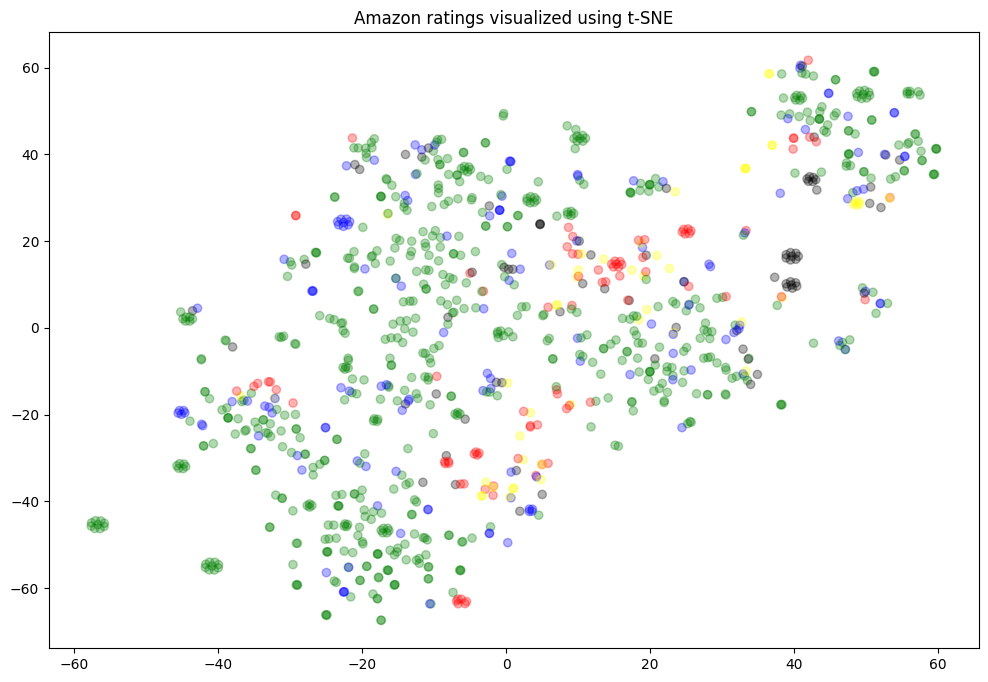

In [217]:

df = pd.read_csv('./EmbeddingsDemoAssets/fine_food_reviews_with_embeddings_large_1k.csv')
matrix = df["embedding"].apply(eval).tolist()

# Convert the list of lists into a NumPy array
matrix_np = np.array(matrix)

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix_np)

colors = ["red", "yellow", "black", "blue", "green"]
x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.title("Amazon ratings visualized using t-SNE")
plt.show()


## Zero-Shot Classification
We can use embeddings for zero shot classification without any labeled training data. For each class, we embed the class name or a short description of the class. To classify some new text in a zero-shot manner, we compare its embedding to all class embeddings and predict the class with the highest similarity.

In [218]:

df= df[df.Score!=3]
df['sentiment'] = df.Score.replace({1:'negative', 2:'negative', 4:'positive', 5:'positive'})

labels = ['negative', 'positive']
label_embeddings = [get_embedding(label, model='text-embedding-3-large') for label in labels]

def label_score(review_embedding, label_embeddings):
   return strings_ranked_by_relatedness(review_embedding, label_embeddings[1]) - strings_ranked_by_relatedness(review_embedding, label_embeddings[0])

prediction = 'positive' if label_score('Sample Review', label_embeddings) > 0 else 'negative'

AttributeError: 'list' object has no attribute 'iterrows'